In [1]:
# Importing necessary libraries

import os
import csv
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import OneVsRest, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

# Processing Images
### Converting JPEG images into rows of pixels

In [2]:
# Retrieving ground truth data (skin lesion diagnoses)
ground_truth_path = './archive/ISIC2018_Task3_Training_GroundTruth.csv'
ground_truth_df = pd.read_csv(ground_truth_path)

CLASSES = ground_truth_df.columns.to_list()[1:]

In [3]:
# Converting images to pixel numpy arrays
PIXELS = 8
TOTAL_PIXELS = (PIXELS ** 2) * 3
IMG_DIRS = ['./archive/HAM10000_images_part_1/', './archive/HAM10000_images_part_2/']

header = [f'pixel{i:04}' for i in range(PIXELS * PIXELS * 3)] + CLASSES + ['image']
data = [header]
for IMG_DIR in IMG_DIRS:
    print(f'Working through: {IMG_DIR}')
    for img in os.listdir(IMG_DIR):
        # Getting pixel values from original jpg image
        bgr_array = cv2.imread(os.path.join(IMG_DIR, img), cv2.IMREAD_COLOR)
        bgr_pil = Image.fromarray(bgr_array)
        bgr_resized = np.array(bgr_pil.resize((PIXELS, PIXELS)))
        bgr_array = bgr_resized.flatten()

        # Restructuring from BGR to RGB
        rgb_list = []
        for i in range(PIXELS ** 2):
            b, g, r = bgr_array[(3 * i):(i * 3) + 3]
            rgb_list += [r, g, b]
        rgb_array = np.array(rgb_list)

        # Getting classification
        img_id = img.split('.')[0]
        classification_array = ground_truth_df.loc[ground_truth_df['image'] == img_id, CLASSES].to_numpy()
        instance_array = np.append(rgb_array, classification_array)
        instance_array = np.append(instance_array, img_id)

        # Adding image data to data list
        data.append(instance_array.tolist())

print(f'Amount of rows: {len(data)}')
print(f'Values per row: {len(data[0])}')

Working through: ./archive/HAM10000_images_part_1/
Working through: ./archive/HAM10000_images_part_2/
Amount of rows: 10016
Values per row: 200


In [4]:
# Preparing plotting functionality

def plot_image(data):
    array = np.array(data)
    corrected = array.astype(float).astype(int)
    image = corrected.reshape(PIXELS, PIXELS, 3)
    plt.imshow(image)

    plt.axis('off')

Example of pixelated images:


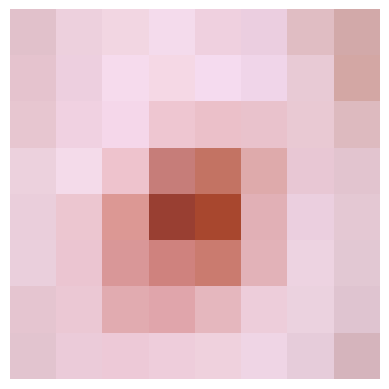

In [5]:
# Plotting an example image
print('Example of pixelated images:')
plot_image(data[1][:-8])

In [6]:
# Separating header from data
header, hmnist = data[0], data[1:]

# Data Stratification
### Diving data to contain an equal percentage of each class in train and test data

In [7]:
# Combining pixels and meta data
META_DIR = './archive/HAM10000_metadata.csv'

hmnist_all = []
with open(META_DIR, 'r') as f:
    csv_reader = csv.reader(f)

    # Ignore header
    next(csv_reader)

    # Combining pixel and meta information
    for line in csv_reader:
        img_data = None # For pixels and ohe labels
        for i, img_id in enumerate([elems[-1] for elems in hmnist]):
            if img_id == line[2]:
                img_data = hmnist[i][:-1]
                break
        meta_data = line[4:]
        dx = line[3]
        instance = img_data[:TOTAL_PIXELS] + meta_data + img_data[TOTAL_PIXELS:] + [dx]
        hmnist_all.append(instance)

print(f'Amount of rows: {len(hmnist_all)}')
print(f'Values per row: {len(hmnist_all[0])}')

Amount of rows: 10015
Values per row: 205


In [8]:
# Identifying label distribution
unique_labels = {}
for instance in hmnist_all:
    label = instance[-1]
    if label not in unique_labels:
        unique_labels[label] = 0
    unique_labels[label] += 1

print('Label distribution in data:')
for label in unique_labels:
    total = unique_labels[label]
    train = round(0.85 * total)
    test = total - train
    print(f'{label}:\t{total}\t -> Train: {train}\t| Test: {test}')

Label distribution in data:
bkl:	1099	 -> Train: 934	| Test: 165
nv:	6705	 -> Train: 5699	| Test: 1006
df:	115	 -> Train: 98	| Test: 17
mel:	1113	 -> Train: 946	| Test: 167
vasc:	142	 -> Train: 121	| Test: 21
bcc:	514	 -> Train: 437	| Test: 77
akiec:	327	 -> Train: 278	| Test: 49


In [9]:
# Stratifying data
for label, count in unique_labels.items():
    unique_labels[label] = round(0.85 * count)

hmnist_train, hmnist_test = [], []
for instance in hmnist_all:
    label = instance[-1]
    if unique_labels[label] > 0:
        hmnist_train.append(instance[:-1])
        unique_labels[label] -= 1
    else:
        hmnist_test.append(instance[:-1])

print(f'Total training images: {len(hmnist_train)}')
print(f'Total testing images: {len(hmnist_test)}')

Total training images: 8513
Total testing images: 1502


# Data Augmentation
### Adding variety to data by rotating and flipping images

In [10]:
# Rotating images
rotated_instances = { 1: [], 2: [], 3: [] }
for rotation in rotated_instances:
    for instance in hmnist_train:
        img_data, meta_data = instance[:TOTAL_PIXELS], instance[TOTAL_PIXELS:]
        img_array = np.array(img_data)
        img = img_array.reshape(PIXELS, PIXELS, 3)
        rotated_image = np.rot90(img, rotation)
        flattened_image = rotated_image.flatten()
        img_data = flattened_image.tolist()
        all_data = img_data + meta_data
        rotated_instances[rotation].append(all_data)

total_rotations = 0
for rotation in rotated_instances:
    total_rotations += len(rotated_instances[rotation])
                           
print(f'Rotations finished. Generated {total_rotations} rotated images.')

# Adding original (non-rotated) images
hmnist_aug_train = hmnist_train + rotated_instances[1] + rotated_instances[2] + rotated_instances[3]
print(f'Total training images is now: {len(hmnist_aug_train)}')

Rotations finished. Generated 25539 rotated images.
Total training images is now: 34052


# Preparing Data for Training

In [11]:
# Creating pandas dataframe
full_header = header[:TOTAL_PIXELS] + ['dx_type', 'age', 'sex', 'localization', 'threat'] + header[TOTAL_PIXELS:-1]
hmnist_pd_df = pd.DataFrame(hmnist_aug_train, columns=full_header)
hmnist_pd_df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,sex,localization,threat,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,199.0,157.0,189.0,210.0,166.0,198.0,216.0,176.0,203.0,215.0,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,117.0,88.0,116.0,178.0,132.0,158.0,201.0,154.0,189.0,215.0,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,203.0,146.0,164.0,209.0,145.0,154.0,217.0,160.0,181.0,215.0,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,138.0,97.0,112.0,195.0,139.0,153.0,209.0,149.0,159.0,211.0,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,205.0,157.0,188.0,229.0,183.0,213.0,232.0,192.0,217.0,218.0,...,male,ear,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# Converting pixel columns to numericals
pixel_cols = header[:TOTAL_PIXELS]
hmnist_pd_df[pixel_cols] = hmnist_pd_df[pixel_cols].astype(float).astype(int)
hmnist_pd_df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,sex,localization,threat,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,199,157,189,210,166,198,216,176,203,215,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,117,88,116,178,132,158,201,154,189,215,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,203,146,164,209,145,154,217,160,181,215,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,138,97,112,195,139,153,209,149,159,211,...,male,scalp,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,205,157,188,229,183,213,232,192,217,218,...,male,ear,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
# Starting Spark Session
spark = (SparkSession
         .builder
         .appName('SkinLesionsML')
         .config('spark.driver.memory', '10g')
         .getOrCreate()
         )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 12:34:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/16 12:34:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [14]:
# Creating spark dataframe
hmnist_spark_df = spark.createDataFrame(hmnist_pd_df)
hmnist_spark_df.show()

23/12/16 12:35:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
23/12/16 12:35:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------

In [15]:
# Adding Label column
hmnist_spark_df = hmnist_spark_df.withColumn(
    'label',
    F.when(F.col('MEL') == 1.0, 0)
    .when(F.col('NV') == 1.0, 1)
    .when(F.col('BCC') == 1.0, 2)
    .when(F.col('AKIEC') == 1.0, 3)
    .when(F.col('BKL') == 1.0, 4)
    .when(F.col('DF') == 1.0, 5)
    .when(F.col('VASC') == 1.0, 6)
)
hmnist_spark_df.show()

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------

In [16]:
#Showing unique values for categorical columns
categorical_cols = ['dx_type', 'sex', 'localization', 'threat']
for col in categorical_cols:
    hmnist_spark_df.select(col).distinct().show()

23/12/16 12:35:57 WARN TaskSetManager: Stage 2 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:35:58 WARN TaskSetManager: Stage 5 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


+---------+
|  dx_type|
+---------+
| confocal|
|consensus|
|    histo|
|follow_up|
+---------+

+-------+
|    sex|
+-------+
| female|
|   male|
|unknown|
+-------+



23/12/16 12:35:58 WARN TaskSetManager: Stage 8 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


+---------------+
|   localization|
+---------------+
|        abdomen|
|          chest|
|           hand|
|           back|
|           face|
|        unknown|
|        genital|
|          trunk|
|           foot|
|            ear|
|           neck|
|upper extremity|
|          scalp|
|lower extremity|
|          acral|
+---------------+



23/12/16 12:35:59 WARN TaskSetManager: Stage 11 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


+---------+
|   threat|
+---------+
|malignant|
|     both|
|   benign|
+---------+



In [17]:
# One Hot Enconding unique meta values
idx_output_cols = [col + '_idx' for col in categorical_cols]
ohe_output_cols = [col + '_ohe' for col in categorical_cols]

str_indexer = StringIndexer(
    inputCols=categorical_cols,
    outputCols=idx_output_cols
)

ohe_enconder = OneHotEncoder(
    inputCols=idx_output_cols,
    outputCols=ohe_output_cols
)

vec_assembler = VectorAssembler(
    inputCols=ohe_output_cols + pixel_cols,
    outputCol='features'
)

sid_mdl = str_indexer.fit(hmnist_spark_df)
hmnist_sid_df = sid_mdl.transform(hmnist_spark_df)

ohe_mdl = ohe_enconder.fit(hmnist_sid_df)
hmnist_ohe_df = ohe_mdl.transform(hmnist_sid_df)

hmnist_vec_df = vec_assembler.transform(hmnist_ohe_df)

23/12/16 12:35:59 WARN TaskSetManager: Stage 14 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


In [18]:
# Preparing pipeline
pipeline = Pipeline(stages=[str_indexer, ohe_enconder, vec_assembler])
pipeline_mdl = pipeline.fit(hmnist_spark_df)
pipeline_df = pipeline_mdl.transform(hmnist_spark_df)
pipeline_df.show(n=5, truncate=False)

23/12/16 12:36:00 WARN TaskSetManager: Stage 17 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------

# Training Model

In [19]:
# ML Model
classification_mdl = LinearSVC()
ovr = OneVsRest(classifier=classification_mdl)
ovr_mdl = ovr.fit(pipeline_df)

23/12/16 12:36:02 WARN TaskSetManager: Stage 21 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:36:02 WARN TaskSetManager: Stage 24 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:36:03 WARN TaskSetManager: Stage 25 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:36:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/16 12:36:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/12/16 12:36:05 WARN TaskSetManager: Stage 27 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:36:06 WARN TaskSetManager: Stage 29 contains a task of very large size (1436 KiB). The maximum recommended task size is 1000 KiB.
23/12/16 12:36:06 WARN TaskSetManager: Stage 31 contains a task of very l

# Testing Model

In [20]:
# Creating pandas test df
hmnist_test_pd_df = pd.DataFrame(hmnist_test, columns=full_header)
hmnist_test_pd_df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,sex,localization,threat,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,177.0,139.0,152.0,194.0,161.0,174.0,200.0,170.0,185.0,197.0,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,170.0,145.0,144.0,185.0,162.0,163.0,190.0,168.0,170.0,186.0,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,186.0,155.0,162.0,206.0,173.0,181.0,218.0,185.0,194.0,216.0,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,173.0,142.0,130.0,202.0,169.0,162.0,221.0,190.0,189.0,229.0,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,227.0,186.0,188.0,238.0,205.0,215.0,242.0,214.0,226.0,238.0,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# Converting pixel columns to numericals
hmnist_test_pd_df[pixel_cols] = hmnist_test_pd_df[pixel_cols].astype(float).astype(int)
hmnist_test_pd_df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,sex,localization,threat,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,177,139,152,194,161,174,200,170,185,197,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,170,145,144,185,162,163,190,168,170,186,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,186,155,162,206,173,181,218,185,194,216,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,173,142,130,202,169,162,221,190,189,229,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,227,186,188,238,205,215,242,214,226,238,...,male,back,benign,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
# Creating spark test dataframe
hmnist_test_spark_df = spark.createDataFrame(hmnist_test_pd_df)
hmnist_test_spark_df.show()

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------

In [23]:
# Adding Label column
hmnist_test_spark_df = hmnist_test_spark_df.withColumn(
    'label',
    F.when(F.col('MEL') == 1.0, 0)
    .when(F.col('NV') == 1.0, 1)
    .when(F.col('BCC') == 1.0, 2)
    .when(F.col('AKIEC') == 1.0, 3)
    .when(F.col('BKL') == 1.0, 4)
    .when(F.col('DF') == 1.0, 5)
    .when(F.col('VASC') == 1.0, 6)
)
hmnist_test_spark_df.show()

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------

In [24]:
# obtain evaluator
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

# compute the classification error on test data
test_instances_df = pipeline_mdl.transform(hmnist_test_spark_df)
test_preds_df = ovr_mdl.transform(test_instances_df)
accuracy = evaluator.evaluate(test_preds_df)
print(f'Test Accuracy = {accuracy}')

Test Accuracy = 0.6957390146471372


In [25]:
# Stopping application
spark.stop()